<a href="https://colab.research.google.com/github/dantv2002/PracticeML/blob/main/review_resnet_from_scratch_blood_cell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, \
  Conv2D, BatchNormalization, ZeroPadding2D, MaxPooling2D, Activation, add, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

In [ ]:
# Download data
# https://www.kaggle.com/paultimothymooney/blood-cells

!wget -nc https://archive.org/download/blood_cell_images/blood_cell_images.zip
!unzip -nq blood_cell_images.zip
!rm blood_cell_images.zip
!ls

--2024-01-13 17:16:51--  https://archive.org/download/blood_cell_images/blood_cell_images.zip
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia801204.us.archive.org/14/items/blood_cell_images/blood_cell_images.zip [following]
--2024-01-13 17:16:51--  https://ia801204.us.archive.org/14/items/blood_cell_images/blood_cell_images.zip
Resolving ia801204.us.archive.org (ia801204.us.archive.org)... 207.241.228.24
Connecting to ia801204.us.archive.org (ia801204.us.archive.org)|207.241.228.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109834540 (105M) [application/zip]
Saving to: ‘blood_cell_images.zip’

blood_cell_images.z 100%[===================>] 104.75M  3.39MB/s    in 28s     

2024-01-13 17:17:20 (3.72 MB/s) - ‘blood_cell_images.zip’ saved [109834540/109834540]

blood_cell_images  __MACOSX  sample_data


In [ ]:
# dataset Width x Height : 640 x 480
# resize to 224x224
IMAGE_SIZE = [224, 224]

# training config:
epochs = 30
batch_size = 128

train_path = 'blood_cell_images/TRAIN'
valid_path = 'blood_cell_images/TEST'

# get number of files
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')
# get number of classes
folders = glob(train_path + '/*')

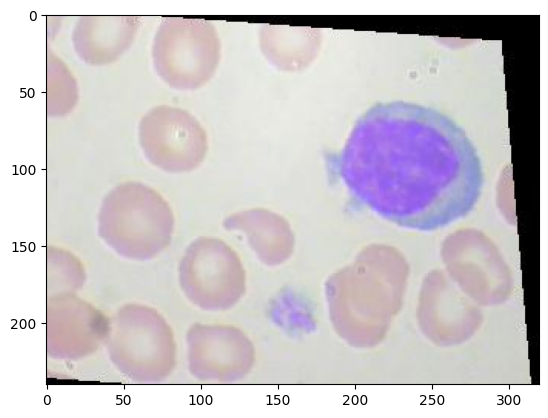

In [ ]:
# pick up an image
plt.imshow(image.load_img(np.random.choice(image_files)));

In [ ]:
def identity_block(input_, kernel_size, filters):
    f1, f2, f3 = filters

    x = Conv2D(f1, (1, 1),
               kernel_initializer='he_normal'
    )(input_)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f2, kernel_size, padding='same',
               kernel_initializer='he_normal'
    )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f3, (1, 1),
               kernel_initializer='he_normal'
    )(x)
    x = BatchNormalization()(x)

    x = add([x, input_])
    x = Activation('relu')(x)
    return x

def conv_block(input_,
               kernel_size,
               filters,
               strides=(2, 2)):
    f1, f2, f3 = filters

    x = Conv2D(f1, (1, 1), strides=strides,
               kernel_initializer='he_normal'
    )(input_)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f2, kernel_size, padding='same',
               kernel_initializer='he_normal'
    )(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(f3, (1, 1),
               kernel_initializer='he_normal'
    )(x)
    x = BatchNormalization()(x)

    shortcut = Conv2D(f3, (1, 1), strides=strides,
                      kernel_initializer='he_normal'
    )(input_)
    shortcut = BatchNormalization()(shortcut)

    x = add([x, shortcut])
    x = Activation('relu')(x)
    return x

In [ ]:
# custom resnet model
inputs = Input(shape=IMAGE_SIZE + [3])
x = ZeroPadding2D(padding=(3, 3))(inputs)
x = Conv2D(64, (7, 7),
           strides=(2, 2),
           padding='valid',
           kernel_initializer='he_normal'
           )(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = ZeroPadding2D(padding=(1, 1))(x)
x = MaxPooling2D((3, 3), strides=(2, 2))(x)

x = conv_block(x, 3, [64, 64, 256], strides=(1, 1))
x = identity_block(x, 3, [64, 64, 256])
x = identity_block(x, 3, [64, 64, 256])

x = conv_block(x, 3, [128, 128, 512])
x = identity_block(x, 3, [128, 128, 512])
x = identity_block(x, 3, [128, 128, 512])
x = identity_block(x, 3, [128, 128, 512])

x = Flatten()(x)
# x = Dense(1024, activation='relu')(x)
# x = Dropout(0.3) (x)
outputs = Dense(len(folders), activation='softmax')(x)

In [ ]:
# Create the model then compile
model = Model(inputs=inputs, outputs=outputs)

model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer=Adam(learning_rate=0.0001),
  metrics=['accuracy']
)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_5 (ZeroPadd  (None, 230, 230, 3)          0         ['input_4[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv2d_48 (Conv2D)          (None, 112, 112, 64)         9472      ['zero_padding2d_5[0][0]']    
                                                                                                  
 batch_normalization_48 (Ba  (None, 112, 112, 64)         256       ['conv2d_48[0][0]']     

In [ ]:
# create an instance of ImageDataGenerator
def preprocess_input2(x):
  x /= 127.5
  x -= 1.
  return x

train_gen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input2
)

val_gen = ImageDataGenerator(
  preprocessing_function=preprocess_input2
)

In [ ]:
# test generator to see how it works and some other useful things

# get label mapping for confusion matrix plot later
test_gen = val_gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE, class_mode='sparse')
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

Found 2487 images belonging to 4 classes.
{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}


min: -1.0 max: 1.0


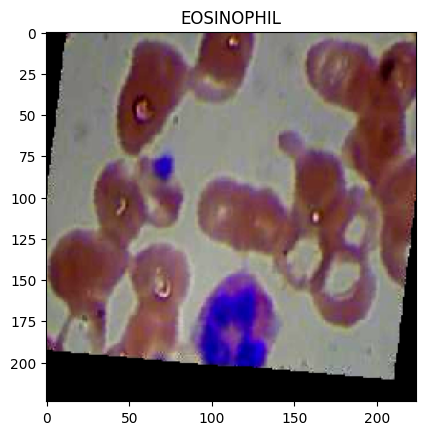

In [ ]:
for x, y in test_gen:
  print("min:", x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

In [ ]:
# create generators
train_generator = train_gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
  class_mode='sparse',
)
valid_generator = val_gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
  class_mode='sparse',
)

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [ ]:
# train the model
checkpoint_filepath = '/tmp/checkpoint'
logs = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=epochs,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
  callbacks=[
    EarlyStopping(
      monitor='loss', patience=epochs//10, restore_best_weights=True),
    ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=True,
      monitor='val_accuracy',
      mode='max',
      save_best_only=True),
  ]
)

Epoch 1/30
77/77 [==============================] - 223s 3s/step - loss: 9.1071 - accuracy: 0.2844 - val_loss: 2.3460 - val_accuracy: 0.2833
Epoch 2/30
77/77 [==============================] - 160s 2s/step - loss: 1.9956 - accuracy: 0.4394 - val_loss: 2.0209 - val_accuracy: 0.3935
Epoch 3/30
77/77 [==============================] - 160s 2s/step - loss: 1.5451 - accuracy: 0.5988 - val_loss: 1.7987 - val_accuracy: 0.4955
Epoch 4/30
77/77 [==============================] - 158s 2s/step - loss: 0.8144 - accuracy: 0.7553 - val_loss: 1.5499 - val_accuracy: 0.6135
Epoch 5/30
77/77 [==============================] - 156s 2s/step - loss: 0.5306 - accuracy: 0.8471 - val_loss: 1.1820 - val_accuracy: 0.7011
Epoch 6/30
77/77 [==============================] - 156s 2s/step - loss: 0.5330 - accuracy: 0.8665 - val_loss: 2.5424 - val_accuracy: 0.6049
Epoch 7/30
77/77 [==============================] - 153s 2s/step - loss: 0.4910 - accuracy: 0.8941 - val_loss: 2.2782 - val_accuracy: 0.7204
Epoch 8/30
77

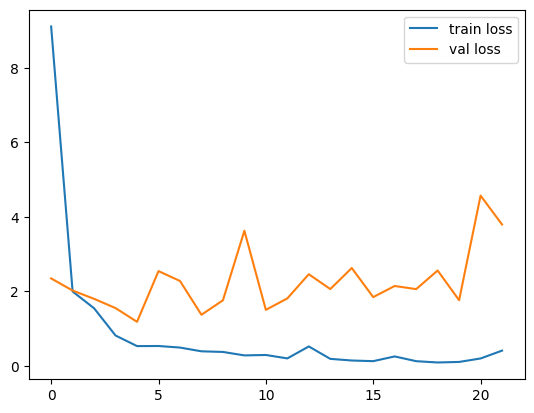

In [ ]:
# loss
plt.plot(logs.history['loss'], label='train loss')
plt.plot(logs.history['val_loss'], label='val loss')
plt.legend()
plt.show()

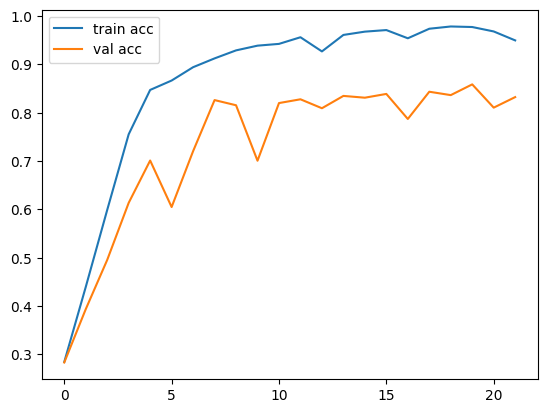

In [ ]:
# accuracies
plt.plot(logs.history['accuracy'], label='train acc')
plt.plot(logs.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [ ]:
model.load_weights(checkpoint_filepath)

In [ ]:
def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in val_gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm

In [ ]:
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)

Generating confusion matrix 9957
Found 9957 images belonging to 4 classes.
8/8 [==============================] - 2s 130ms/step
[[2497    0    0    0]
 [   2 2481    0    0]
 [   0    0 2478    0]
 [ 253    2   64 2180]]
Generating confusion matrix 2487
Found 2487 images belonging to 4 classes.
6/6 [==============================] - 1s 212ms/step
[[525   0   5  93]
 [  0 607  10   3]
 [ 62   0 555   3]
 [152   6  18 448]]


In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion matrix, without normalization
[[2497    0    0    0]
 [   2 2481    0    0]
 [   0    0 2478    0]
 [ 253    2   64 2180]]


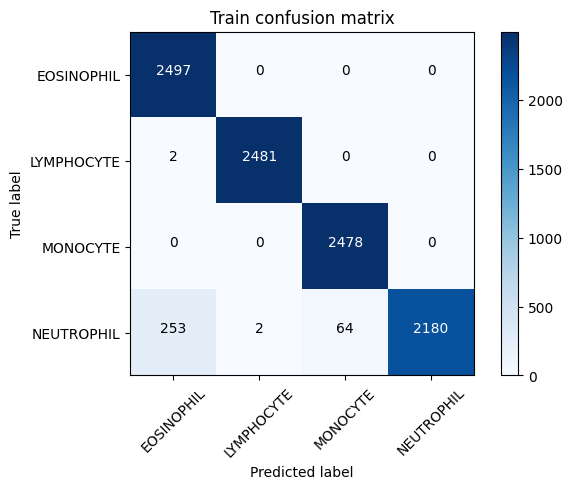

In [ ]:
plot_confusion_matrix(cm, labels, title='Train confusion matrix')

In [ ]:
np.trace(cm) / cm.sum()

0.9677613739078036

Confusion matrix, without normalization
[[525   0   5  93]
 [  0 607  10   3]
 [ 62   0 555   3]
 [152   6  18 448]]


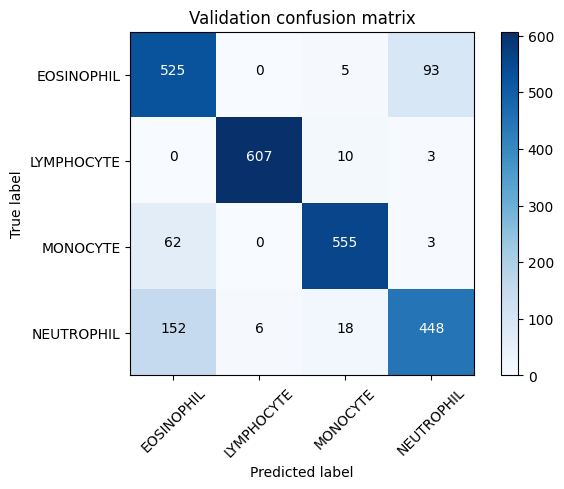

In [ ]:
plot_confusion_matrix(valid_cm, labels, title='Validation confusion matrix')

In [ ]:
np.trace(valid_cm) / valid_cm.sum()

0.8584640128669079